In [1]:

import pandas as pd
import numpy as np
import histlite as hl
import uproot as up
import pickle
import os

from matplotlib import pyplot as plt 

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'sans-serif'})

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})

In [2]:
runlist = [136, 138, 139, 140, 141, 142, 143, 144, 145, 146,
            147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
            157, 158,
            180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
            190, 191, 192, 194, 195,
            200, 201, 202, 206, 207, 208, 209, 210, 211,
            212, 213, 214, 215, 216, 220, 223,
            224, 225, 229, 231, 234, 235, 238, 239, 240,
            241, 242, 243, 244, 247, 248, 250, 253, 254, 255, 
            257, 258, 259, 261, 262,
            264, 265, 266, 267, 270, 271, 273, 276, 277, 279,
            285, 287, 288, 311, 312, 313,
            314, 319, 320, 321, 322, 324, 327, 329, 331,
            332, 333, 340, 341, 342, 343, 344, 347, 348, 350,
            352, 353, 354, 355, 356, 358, 359, 360, 361, 362,
            363, 364, 365, 366, 367, 371, 372]
detlist = ['ge0', 'ge2', 'ge4', 'ge6']
histdict = {}
datadir = '/p/lustre1/lenardo1/tunl_cs136_data/'

for det in detlist:
    histdict[det] = {}
    print('Detector {}'.format(det))
    for run in runlist:
        
        if det == 'ge0' or det == 'ge2':
            erange = '0-700'
        else:
            erange = '0-3200'
        
        histfile = 'root_data_Xe136_run{}hist_{}_{}_no_time_cut.pkl'.format(run,erange,det)
        
        #print('\tLoading {}...'.format(run))

        if histfile in os.listdir(datadir + 'histograms/'):
            #print('\t\tLoading histogram from file...')
            with open(datadir + 'histograms/' + histfile, 'rb') as pklfile:
                histdict[det][run] = pickle.load(pklfile)
        else:
            print('\t\tMISSING HISTOGRAM FOR RUN {}'.format(run))
        
        
    
    



Detector ge0
Detector ge2
		MISSING HISTOGRAM FOR RUN 229
		MISSING HISTOGRAM FOR RUN 342
		MISSING HISTOGRAM FOR RUN 343
		MISSING HISTOGRAM FOR RUN 367
Detector ge4
		MISSING HISTOGRAM FOR RUN 229
		MISSING HISTOGRAM FOR RUN 342
		MISSING HISTOGRAM FOR RUN 343
		MISSING HISTOGRAM FOR RUN 367
		MISSING HISTOGRAM FOR RUN 371
Detector ge6
		MISSING HISTOGRAM FOR RUN 229
		MISSING HISTOGRAM FOR RUN 342
		MISSING HISTOGRAM FOR RUN 343
		MISSING HISTOGRAM FOR RUN 367
		MISSING HISTOGRAM FOR RUN 371


In [3]:
from scipy.special import erf

def GaussPlusConst( x, A, mu, sig, C):
    return A*np.exp(-(x-mu)**2/(2*sig**2)) + C

def SkewGaussPlusConst( x, A, mu, sig, alpha, C):
    arg = (x-mu/sig)
    return A * 1/np.sqrt(8*np.pi) * \
            np.exp(-arg**2/2.) * \
            (1 + erf(alpha*arg/np.sqrt(2))) + C

def SplitGaussPlusConst( x, A, mu, sig1, sig2, C):
    
    output = np.zeros(len(x))
    output[x>mu] = A*np.exp(-(x[x>mu]-mu)**2/(2*sig2**2)) + C
    output[x<=mu] = A*np.exp(-(x[x<=mu]-mu)**2/(2*sig1**2)) + C
    
    return output


def FitBinsInRange( hist, lower, upper, muguess = None, p0=None):
    
    xdat = (hist.bins[0][1:] + hist.bins[0][:-1])/2.
    ydat = hist.values 
    
    mask = (xdat > lower) & (xdat < upper)
    
    if p0 is None:
        Aguess = np.max(ydat[mask])
        if muguess is None:
            muguess = xdat[ np.where( ydat==np.max(ydat[mask]) )[0][0] ]
        else:
            muguess = muguess
        sigguess = 1.
        Cguess = ydat[mask][0]
        
        p0 = (Aguess, muguess, sigguess, Cguess)
        #print('Guess: {}'.format(p0))

    p, pcov = curve_fit(GaussPlusConst, xdat[mask], ydat[mask],\
                       p0 = p0)
    
    return xdat[mask], ydat[mask], p, pcov

def FitBinsInRangeSkew( hist, lower, upper, muguess = None, p0=None):
    
    xdat = (hist.bins[0][1:] + hist.bins[0][:-1])/2.
    ydat = hist.values 
    
    mask = (xdat > lower) & (xdat < upper)
    
    if p0 is None:
        Aguess = np.max(ydat[mask])
        if muguess is None:
            muguess = xdat[ np.where( ydat==np.max(ydat[mask]) )[0][0] ]
        else:
            muguess = muguess
        sigguess = 1.
        Cguess = ydat[mask][0]
        alphaguess = -4.
        
        p0 = (Aguess, muguess, sigguess, alphaguess, Cguess)
        #print('Guess: {}'.format(p0))

    p, pcov = curve_fit(SkewGaussPlusConst, xdat[mask], ydat[mask],\
                       p0 = p0)
    
    return xdat[mask], ydat[mask], p, pcov, p0

def FitBinsInRangeSplit( hist, lower, upper, muguess = None, p0=None):
    
    xdat = (hist.bins[0][1:] + hist.bins[0][:-1])/2.
    ydat = hist.values 
    
    mask = (xdat > lower) & (xdat < upper)
    
    if p0 is None:
        Aguess = np.max(ydat[mask])
        if muguess is None:
            muguess = xdat[ np.where( ydat==np.max(ydat[mask]) )[0][0] ]
        else:
            muguess = muguess
        sigguess = 0.5
        Cguess = ydat[mask][0]
        
        p0 = (Aguess, muguess, sigguess, sigguess, Cguess)
        #print('Guess: {}'.format(p0))
    try:
        p, pcov = curve_fit(SplitGaussPlusConst, xdat[mask], ydat[mask],\
                       p0 = p0)
    except:
        print('FIT FAILED!')
        p = p0
        pcov = np.zeros((len(p0),len(p0)))
    
    return xdat[mask], ydat[mask], p, pcov, p0



from scipy.optimize import curve_fit

In [4]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams.update({'font.size': 18})

centroid = {} #[]
sig1 = {} #[]
sig2 = {} #[]

centroid_511 = {} #[]
sig1_511 = {} #[]
sig2_511 = {} #[]

showplot = False
fig_counter = 1

for det, subdict in histdict.items():
    
    centroid_tmp = []
    sig1_tmp = []
    sig2_tmp = []
    
        
    centroid_511_tmp = []
    sig1_511_tmp = []
    sig2_511_tmp = []
    
    for run, hist in subdict.items():

        xdat, ydat, p, pcov, p0 = FitBinsInRangeSplit( hist, 234., 246., muguess=239.9)
        centroid_tmp.append([run, p[1], np.sqrt(pcov[1,1]) ])
        sig1_tmp.append([run, p[2], np.sqrt(pcov[2,2]) ])
        sig2_tmp.append([run, p[3], np.sqrt(pcov[3,3]) ])
        
        xdat, ydat, p, pcov, p0 = FitBinsInRangeSplit( hist, 502, 518, muguess=511.)
        centroid_511_tmp.append([run, p[1], np.sqrt(pcov[1,1]) ])
        sig1_511_tmp.append([run, p[2], np.sqrt(pcov[2,2]) ])
        sig2_511_tmp.append([run, p[3], np.sqrt(pcov[3,3]) ])
        
        
        if det=='ge6':
            showplot=False
        else:
            showplot=False
        
        if showplot:
            plt.figure(fig_counter)
            fig_counter += 1
            plt.errorbar( xdat, ydat, yerr=np.sqrt(ydat), fmt='o',\
                        label=det)
            plt.title('{}, Run{}'.format(det, run))
            plt.xlabel('Energy [keV]')
            plt.plot(xdat, SplitGaussPlusConst(xdat,*p), '-r')
            plt.grid()
            plt.show()


    

    
    centroid_tmp = np.array(centroid_tmp)
    sig1_tmp = np.array(sig1_tmp)
    sig2_tmp = np.array(sig2_tmp)
    
    centroid[det] = centroid_tmp
    sig1[det] = sig1_tmp
    sig2[det] = sig2_tmp
    
    


FIT FAILED!
FIT FAILED!
FIT FAILED!


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [5]:
for det, data in centroid.items():
#     print(data)
    filename = '{}_240keV_peak_centroid.csv'.format(det)
    np.savetxt(filename, data, delimiter=',')
    
    
for det, data in centroid_511.items():
#     print(data)
    filename = '{}_511keV_peak_centroid.csv'.format(det)
    np.savetxt(filename, data, delimiter=',')

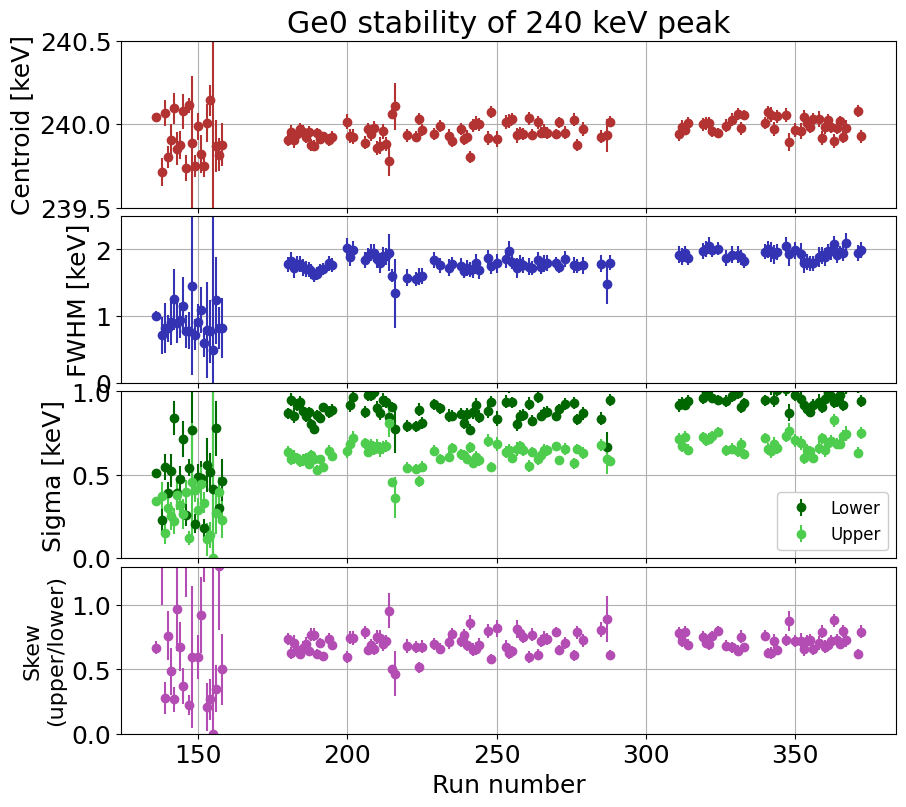

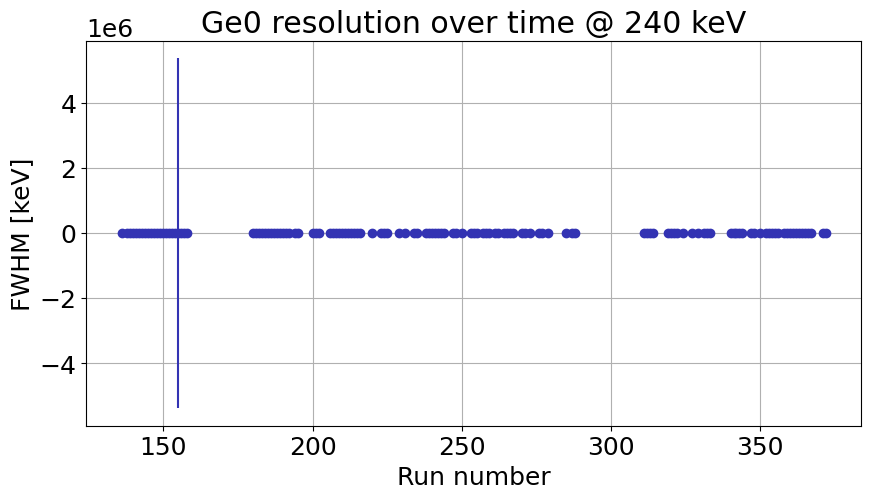

In [6]:
plt.rcParams['figure.figsize'] = [10,9]
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, \
                       gridspec_kw = {'hspace':0.05} )

ax[0].errorbar(centroid['ge0'][:,0], centroid['ge0'][:,1], \
            yerr = centroid['ge0'][:,2], fmt='o', color=(0.7, 0.2, 0.2))
ax[0].set_ylabel('Centroid [keV]')
ax[0].set_ylim(239.5,240.5)
ax[0].grid()


fwhm = (sig1['ge0'][:,1] + sig2['ge0'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge0'][:,2]**2/sig2['ge0'][:,1]**2 +\
                          sig1['ge0'][:,2]**2/sig1['ge0'][:,1]**2)
ax[1].errorbar(sig2['ge0'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
ax[1].set_ylabel('FWHM [keV]')
ax[1].set_ylim(0.,2.5)
ax[1].grid()


ax[2].errorbar(sig1['ge0'][:,0], sig1['ge0'][:,1], \
            yerr = sig1['ge0'][:,2], fmt='o', label='Lower',\
              color=(0., 0.4, 0.))
ax[2].errorbar(sig2['ge0'][:,0], sig2['ge0'][:,1], \
            yerr = sig2['ge0'][:,2], fmt='o', label='Upper',\
              color=(0.3, 0.8, 0.3))
ax[2].legend(fontsize=12, framealpha=1.)
ax[2].set_ylabel('Sigma [keV]')
ax[2].set_ylim(0.,1.)
ax[2].grid()

ax[3].set_xlabel('Run number')

ax[3].set_ylabel('Skew\n(upper/lower)', fontsize=16)

skewness = sig2['ge0'][:,1] / sig1['ge0'][:,1]
skewness_err = skewness * np.sqrt( sig2['ge0'][:,2]**2 / sig2['ge0'][:,1]**2 + \
                      sig1['ge0'][:,2]**2 / sig1['ge0'][:,1]**2 )

ax[3].errorbar(sig2['ge0'][:,0], skewness, yerr=skewness_err,\
              fmt='o', color=(0.7, 0.3, 0.7))
ax[3].grid()
ax[3].set_ylim(0.,1.3)

ax[0].set_title('Ge0 stability of 240 keV peak')

plt.savefig('data_quality_plots/ge0_stability_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')

plt.show()

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 18})
plt.figure(2)
fwhm = (sig1['ge0'][:,1] + sig2['ge0'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge0'][:,2]**2/sig2['ge0'][:,1]**2 +\
                          sig1['ge0'][:,2]**2/sig1['ge0'][:,1]**2)
plt.errorbar(sig2['ge0'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
plt.gca().set_ylabel('FWHM [keV]')
plt.xlabel('Run number')
plt.title('Ge0 resolution over time @ 240 keV')
plt.grid()

plt.savefig('data_quality_plots/ge0_resolution_over_time_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')

plt.show()


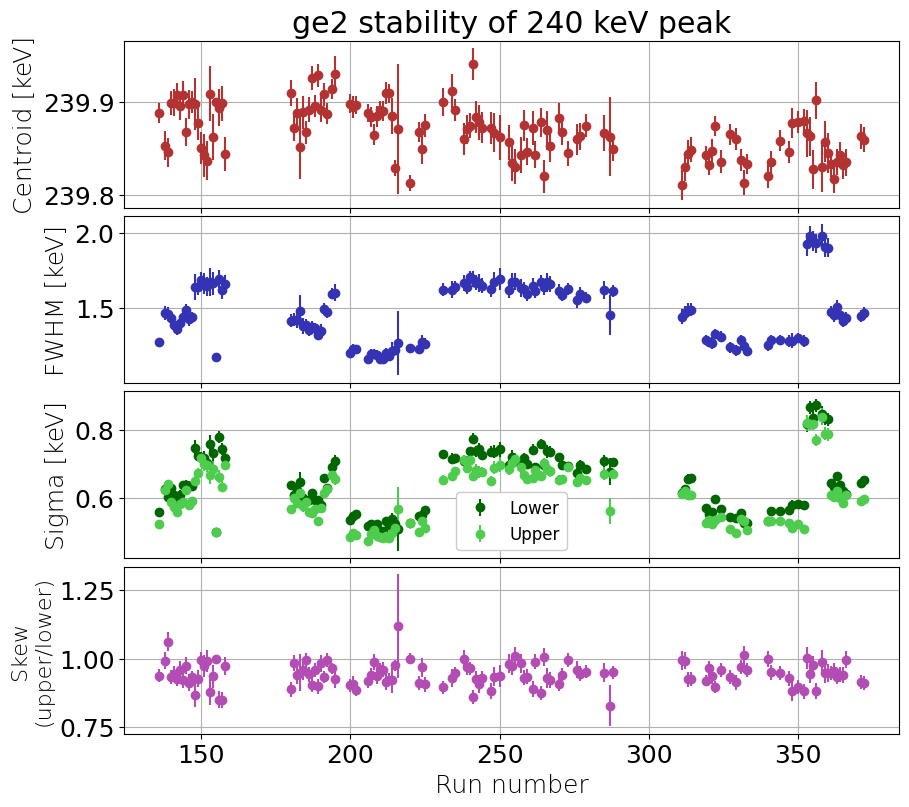

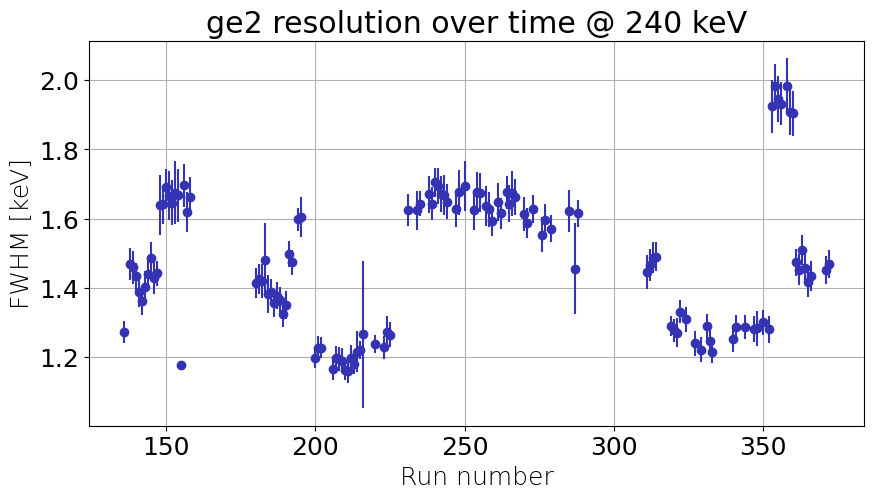

In [8]:
plt.rcParams['figure.figsize'] = [10,9]
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, \
                       gridspec_kw = {'hspace':0.05} )

ax[0].errorbar(centroid['ge2'][:,0], centroid['ge2'][:,1], \
            yerr = centroid['ge2'][:,2], fmt='o', color=(0.7, 0.2, 0.2))
ax[0].set_ylabel('Centroid [keV]')
ax[0].grid()

fwhm = (sig1['ge2'][:,1] + sig2['ge2'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge2'][:,2]**2/sig2['ge2'][:,1]**2 +\
                          sig1['ge2'][:,2]**2/sig1['ge2'][:,1]**2)
ax[1].errorbar(sig2['ge2'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
ax[1].set_ylabel('FWHM [keV]')
ax[1].grid()


ax[2].errorbar(sig1['ge2'][:,0], sig1['ge2'][:,1], \
            yerr = sig1['ge2'][:,2], fmt='o', label='Lower',\
              color=(0., 0.4, 0.))
ax[2].errorbar(sig2['ge2'][:,0], sig2['ge2'][:,1], \
            yerr = sig2['ge2'][:,2], fmt='o', label='Upper',\
              color=(0.3, 0.8, 0.3))
ax[2].legend(fontsize=12, framealpha=1.)
ax[2].set_ylabel('Sigma [keV]')
ax[2].grid()

ax[3].set_xlabel('Run number')

ax[3].set_ylabel('Skew\n(upper/lower)', fontsize=16)

skewness = sig2['ge2'][:,1] / sig1['ge2'][:,1]
skewness_err = skewness * np.sqrt( sig2['ge2'][:,2]**2 / sig2['ge2'][:,1]**2 + \
                      sig1['ge2'][:,2]**2 / sig1['ge2'][:,1]**2 )

ax[3].errorbar(sig2['ge2'][:,0], skewness, yerr=skewness_err,\
              fmt='o', color=(0.7, 0.3, 0.7))
ax[3].grid()

ax[0].set_title('ge2 stability of 240 keV peak')



plt.savefig('data_quality_plots/ge2_stability_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')
plt.show()


plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 18})
plt.figure(2)
fwhm = (sig1['ge2'][:,1] + sig2['ge2'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge2'][:,2]**2/sig2['ge2'][:,1]**2 +\
                          sig1['ge2'][:,2]**2/sig1['ge2'][:,1]**2)
plt.errorbar(sig2['ge2'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
plt.gca().set_ylabel('FWHM [keV]')
plt.xlabel('Run number')
plt.title('ge2 resolution over time @ 240 keV')
plt.grid()

plt.savefig('data_quality_plots/ge2_resolution_over_time_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')
plt.show()


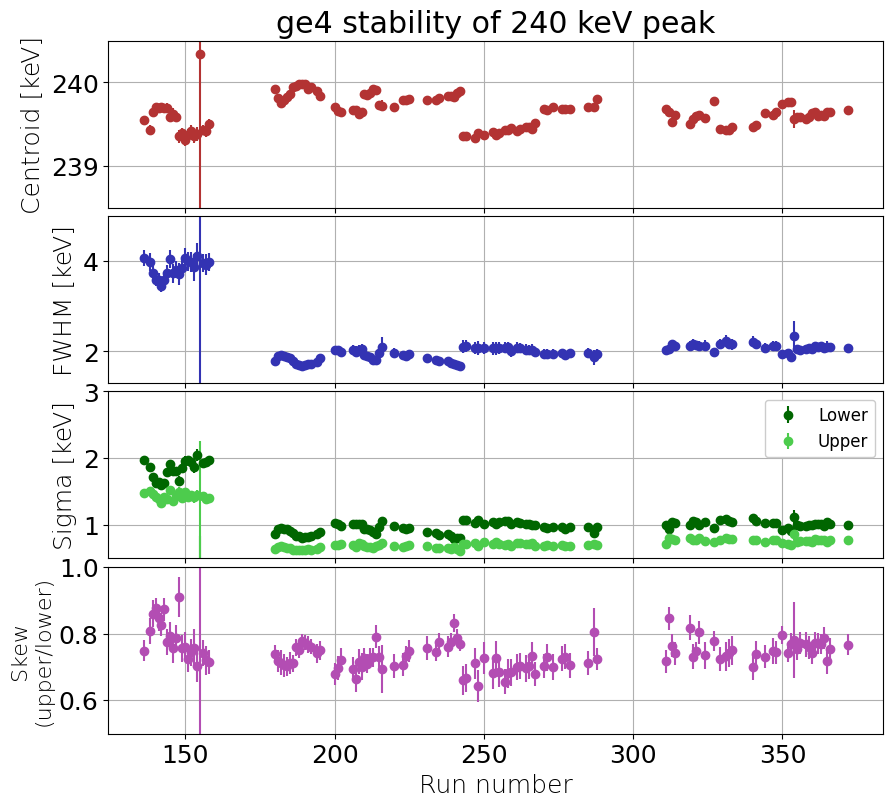

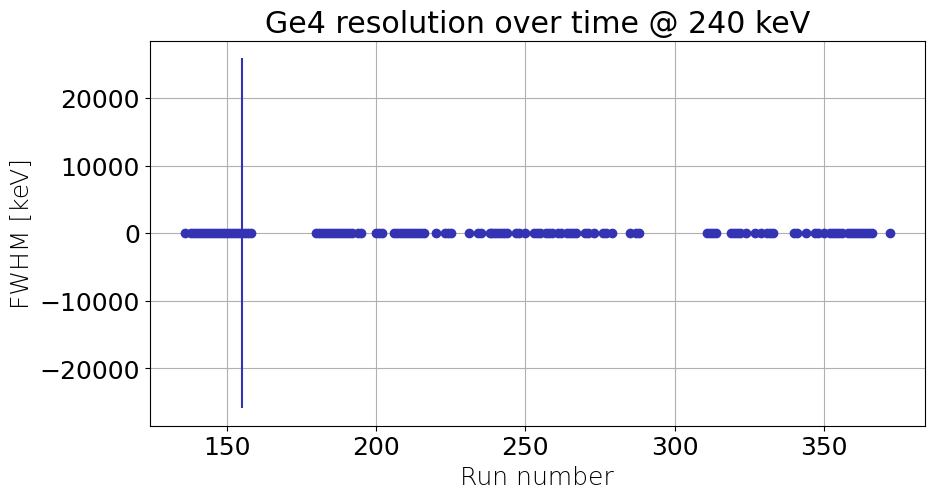

In [9]:
plt.rcParams['figure.figsize'] = [10,9]
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, \
                       gridspec_kw = {'hspace':0.05} )

ax[0].errorbar(centroid['ge4'][:,0], centroid['ge4'][:,1], \
            yerr = centroid['ge4'][:,2], fmt='o', color=(0.7, 0.2, 0.2))
ax[0].set_ylabel('Centroid [keV]')
ax[0].set_ylim(238.5,240.5)
ax[0].grid()

fwhm = (sig1['ge4'][:,1] + sig2['ge4'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge4'][:,2]**2/sig2['ge4'][:,1]**2 +\
                          sig1['ge4'][:,2]**2/sig1['ge4'][:,1]**2)
ax[1].errorbar(sig2['ge4'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
ax[1].set_ylabel('FWHM [keV]')
ax[1].set_ylim(1.3,5.)
ax[1].grid()


ax[2].errorbar(sig1['ge4'][:,0], sig1['ge4'][:,1], \
            yerr = sig1['ge4'][:,2], fmt='o', label='Lower',\
              color=(0., 0.4, 0.))
ax[2].errorbar(sig2['ge4'][:,0], sig2['ge4'][:,1], \
            yerr = sig2['ge4'][:,2], fmt='o', label='Upper',\
              color=(0.3, 0.8, 0.3))
ax[2].legend(fontsize=12, framealpha=1.)
ax[2].set_ylabel('Sigma [keV]')
ax[2].set_ylim(0.5,3.)

ax[2].grid()

ax[3].set_xlabel('Run number')

ax[3].set_ylabel('Skew\n(upper/lower)', fontsize=16)

skewness = sig2['ge4'][:,1] / sig1['ge4'][:,1]
skewness_err = skewness * np.sqrt( sig2['ge4'][:,2]**2 / sig2['ge4'][:,1]**2 + \
                      sig1['ge4'][:,2]**2 / sig1['ge4'][:,1]**2 )

ax[3].errorbar(sig2['ge4'][:,0], skewness, yerr=skewness_err,\
              fmt='o', color=(0.7, 0.3, 0.7))
ax[3].set_ylim(0.5,1.)
ax[3].grid()

ax[0].set_title('ge4 stability of 240 keV peak')


plt.savefig('data_quality_plots/ge4_stability_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')
plt.show()


plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 18})
plt.figure(2)
fwhm = (sig1['ge4'][:,1] + sig2['ge4'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge4'][:,2]**2/sig2['ge4'][:,1]**2 +\
                          sig1['ge4'][:,2]**2/sig1['ge4'][:,1]**2)
plt.errorbar(sig2['ge4'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
plt.gca().set_ylabel('FWHM [keV]')
plt.xlabel('Run number')
plt.title('Ge4 resolution over time @ 240 keV')
plt.grid()

plt.savefig('data_quality_plots/ge4_resolution_over_time_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')

plt.show()




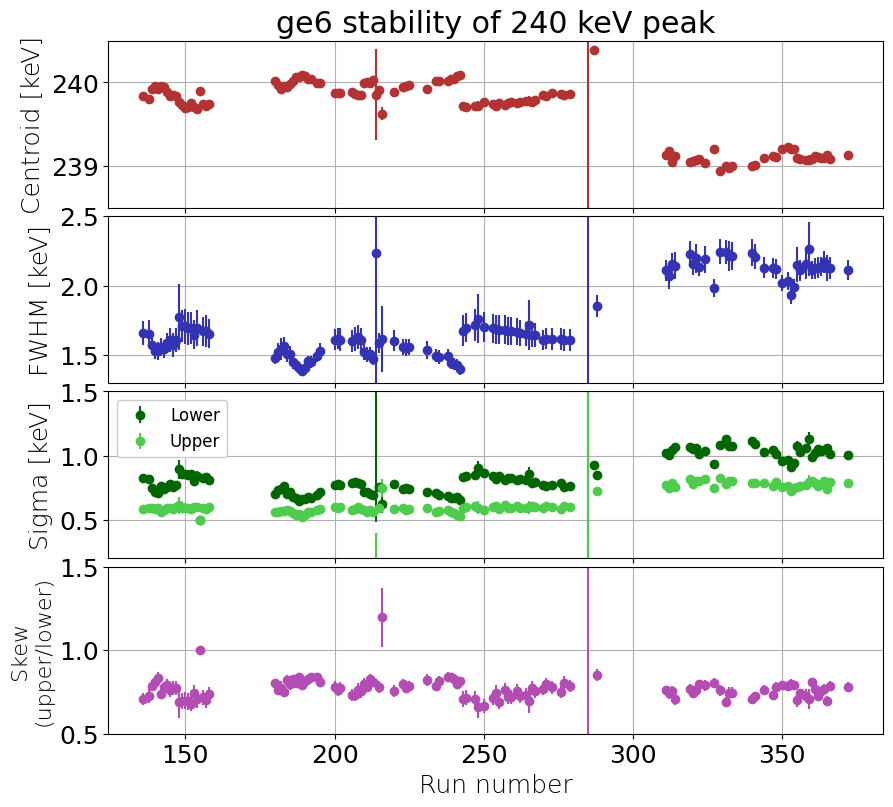

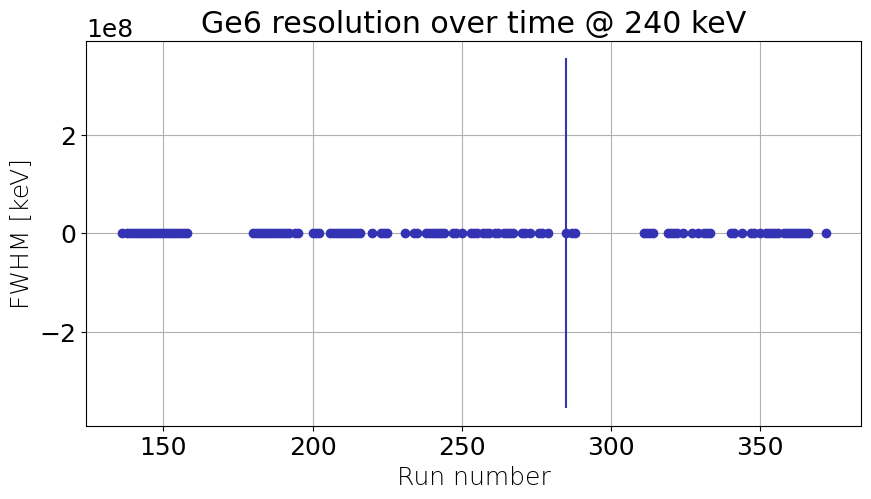

In [10]:
plt.rcParams['figure.figsize'] = [10,9]
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, \
                       gridspec_kw = {'hspace':0.05} )

ax[0].errorbar(centroid['ge6'][:,0], centroid['ge6'][:,1], \
            yerr = centroid['ge6'][:,2], fmt='o', color=(0.7, 0.2, 0.2))
ax[0].set_ylabel('Centroid [keV]')
ax[0].set_ylim(238.5,240.5)
ax[0].grid()

fwhm = (sig1['ge6'][:,1] + sig2['ge6'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge6'][:,2]**2/sig2['ge6'][:,1]**2 +\
                          sig1['ge6'][:,2]**2/sig1['ge6'][:,1]**2)
ax[1].errorbar(sig2['ge6'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
ax[1].set_ylabel('FWHM [keV]')
ax[1].set_ylim(1.3,2.5)
ax[1].grid()


ax[2].errorbar(sig1['ge6'][:,0], sig1['ge6'][:,1], \
            yerr = sig1['ge6'][:,2], fmt='o', label='Lower',\
              color=(0., 0.4, 0.))
ax[2].errorbar(sig2['ge6'][:,0], sig2['ge6'][:,1], \
            yerr = sig2['ge6'][:,2], fmt='o', label='Upper',\
              color=(0.3, 0.8, 0.3))
ax[2].legend(fontsize=12, framealpha=1.)
ax[2].set_ylabel('Sigma [keV]')
ax[2].set_ylim(0.2,1.5)
ax[2].grid()

ax[3].set_xlabel('Run number')

ax[3].set_ylabel('Skew\n(upper/lower)', fontsize=16)

skewness = sig2['ge6'][:,1] / sig1['ge6'][:,1]
skewness_err = skewness * np.sqrt( sig2['ge6'][:,2]**2 / sig2['ge6'][:,1]**2 + \
                      sig1['ge6'][:,2]**2 / sig1['ge6'][:,1]**2 )

ax[3].errorbar(sig2['ge6'][:,0], skewness, yerr=skewness_err,\
              fmt='o', color=(0.7, 0.3, 0.7))
ax[3].set_ylim(0.5,1.5)
ax[3].grid()

ax[0].set_title('ge6 stability of 240 keV peak')


plt.savefig('data_quality_plots/ge6_stability_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')
plt.show()


plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 18})
plt.figure(2)
fwhm = (sig1['ge6'][:,1] + sig2['ge6'][:,1]) * 2.355/2.
fwhm_err = fwhm * np.sqrt( sig2['ge6'][:,2]**2/sig2['ge6'][:,1]**2 +\
                          sig1['ge6'][:,2]**2/sig1['ge6'][:,1]**2)
plt.errorbar(sig2['ge6'][:,0], fwhm, yerr = fwhm_err, \
               color=(0.2, 0.2, 0.7), fmt='o')
plt.gca().set_ylabel('FWHM [keV]')
plt.xlabel('Run number')
plt.title('Ge6 resolution over time @ 240 keV')
plt.grid()

plt.savefig('data_quality_plots/ge6_resolution_over_time_using_240keV_peak.png',\
           dpi=200,bbox_inches='tight')
plt.show()





